In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline



# 1. SETUP & CONSTANTS

In [3]:
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training parameters
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 0.00001 # 1e-5

# 2. LOAD & PREPARE DATASET

In [4]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

# Create a pre-processing layer that will be part of the model
data_augmentation_and_preprocessing = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Lambda(preprocess_input) # Use the official MobileNetV2 preprocessing function
])

# Optimize performance by prefetching data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

# 3. BUILD THE MODEL 

In [5]:
def build_model(num_classes):
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation_and_preprocessing(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

model, base_model = build_model(num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- MODEL SUMMARY (before fine-tuning) ---")
model.summary()




--- MODEL SUMMARY (before fine-tuning) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 4. INITIAL TRAINING (Train only the new head)

In [6]:

print("\n--- STARTING INITIAL TRAINING (HEAD ONLY) ---")
history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset)


--- STARTING INITIAL TRAINING (HEAD ONLY) ---
Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 481s 218ms/step - accuracy: 0.7659 - loss: 0.8653 - val_accuracy: 0.9200 - val_loss: 0.2672
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 477s 217ms/step - accuracy: 0.9164 - loss: 0.2577 - val_accuracy: 0.9319 - val_loss: 0.2133
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 486s 221ms/step - accuracy: 0.9254 - loss: 0.2263 - val_accuracy: 0.9318 - val_loss: 0.2042
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 477s 217ms/step - accuracy: 0.9305 - loss: 0.2068 - val_accuracy: 0.9381 - val_loss: 0.1901
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 28512s 13s/step - accuracy: 0.9320 - loss: 0.1999 - val_accuracy: 0.9396 - val_loss: 0.1864
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 33680s 15s/step - accuracy: 0.9352 - loss: 0.1966 - val_accuracy: 0.9409 - val_loss: 0.1742
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1907s 868ms/step - accuracy: 0.9364 - loss: 0.1901 - val_accuracy: 0.9387 - val_loss: 0.1866
Epoch 8/10
219

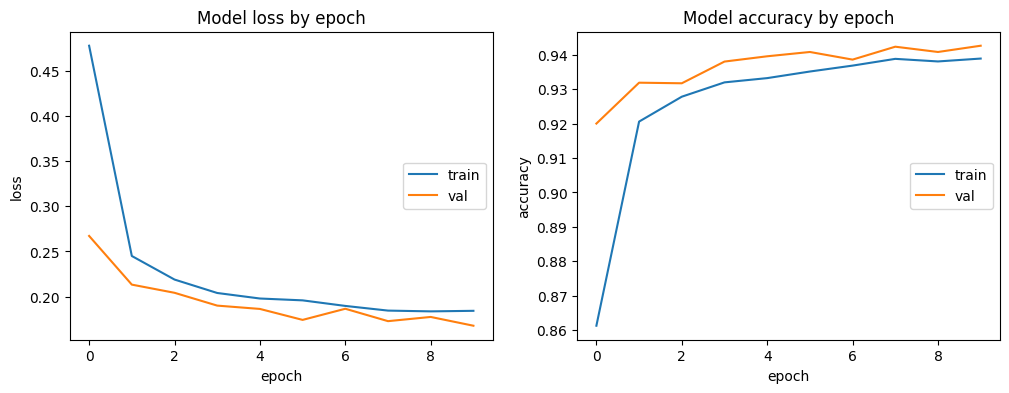

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

2025-07-10 12:42:40.475814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       504
           1       1.00      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       1.00      1.00      1.00       502
           4       0.99      1.00      1.00       454
           5       1.00      0.99      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.92      0.95       410
           8       0.99      1.00      1.00       477
           9       0.93      0.97      0.95       477
          10       1.00      1.00      1.00       465
          11       0.99      0.99      0.99       472
          12       0.99      1.00      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      1.00       503
          16       1.00      0.99      1.00       459
          17       1.00    

<Axes: >

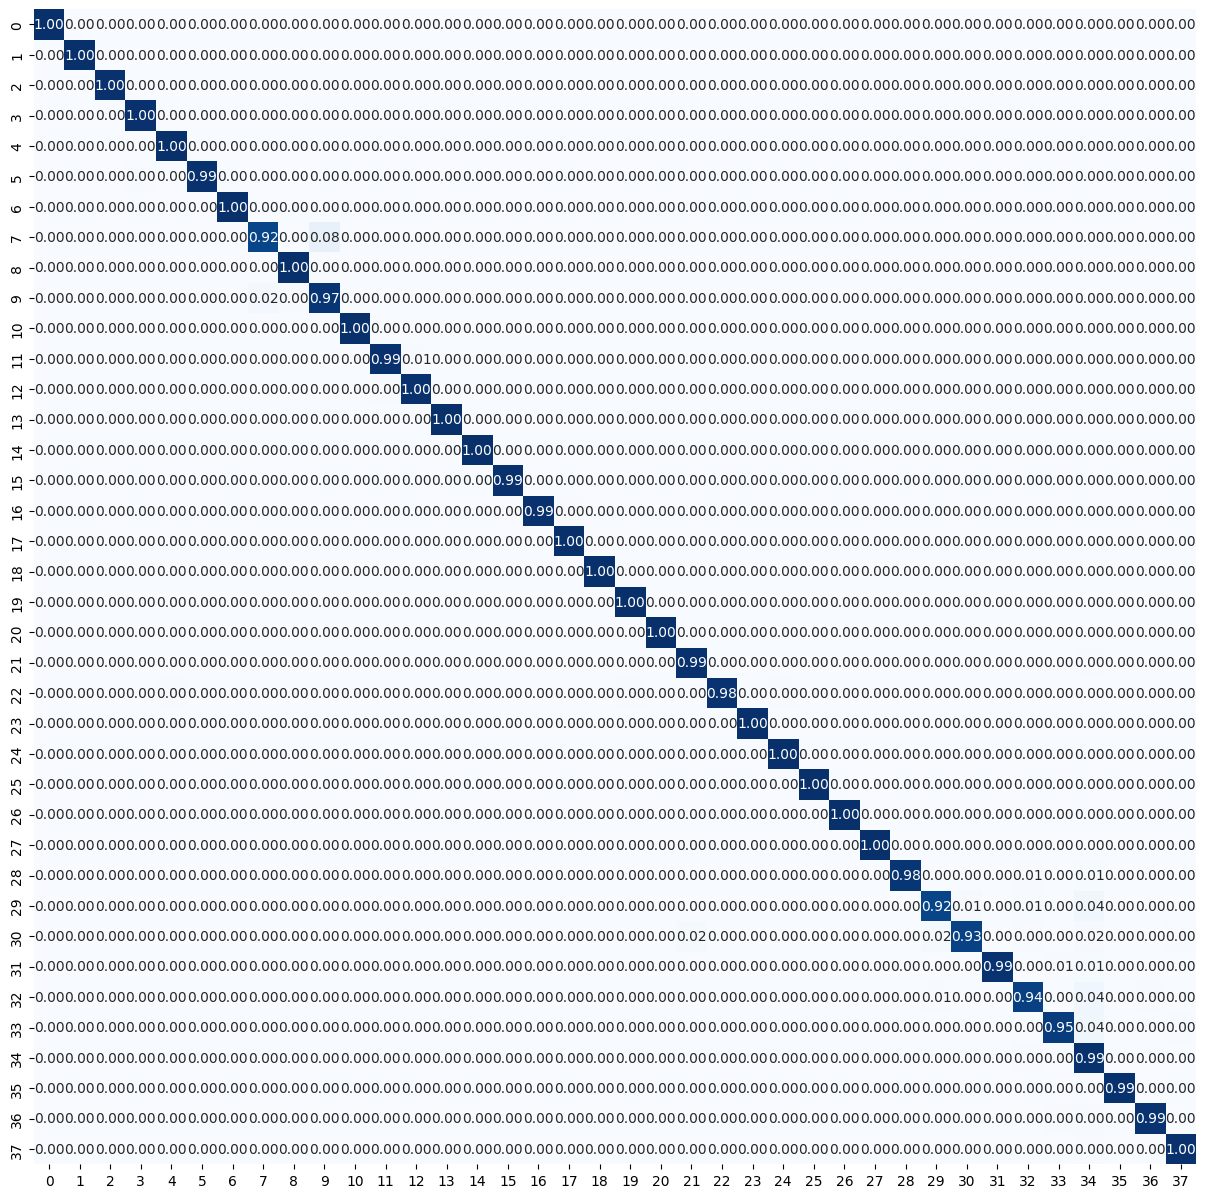

In [18]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(validation_dataset)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap


# 5. FINE-TUNING (Train the whole model with a low learning rate)

In [7]:

print("\n--- STARTING FINE-TUNING (UNFREEZING TOP LAYERS) ---")

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- MODEL SUMMARY (after unfreezing for fine-tuning) ---")
model.summary()

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_dataset)

print("\n--- TRAINING COMPLETE ---")


--- STARTING FINE-TUNING (UNFREEZING TOP LAYERS) ---
Number of layers in the base model:  154

--- MODEL SUMMARY (after unfreezing for fine-tuning) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 10/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 742s 336ms/step - accuracy: 0.7949 - loss: 0.9694 - val_accuracy: 0.9334 - val_loss: 0.2057
Epoch 11/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 721s 328ms/step - accuracy: 0.9260 - loss: 0.2252 - val_accuracy: 0.9533 - val_loss: 0.1406
Epoch 12/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 707s 322ms/step - accuracy: 0.9518 - loss: 0.1468 - val_accuracy: 0.9641 - val_loss: 0.1022
Epoch 13/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 826s 376ms/step - accuracy: 0.9633 - loss: 0.1074 - val_accuracy: 0.9697 - val_loss: 0.0873
Epoch 14/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 694s 316ms/step - accuracy: 0.9680 - loss: 0.0942 - val_accuracy: 0.9733 - val_loss: 0.0749
Epoch 15/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 695s 316ms/step - accuracy: 0.9738 - loss: 0.0751 - val_accuracy: 0.9775 - val_loss: 0.0660
Epoch 16/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 701s 319ms/step - accuracy: 0.9768 - loss: 0.0677 - val_accuracy: 0.9793 - val_loss: 0.0590
Epoch 17/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 695s 316ms/s

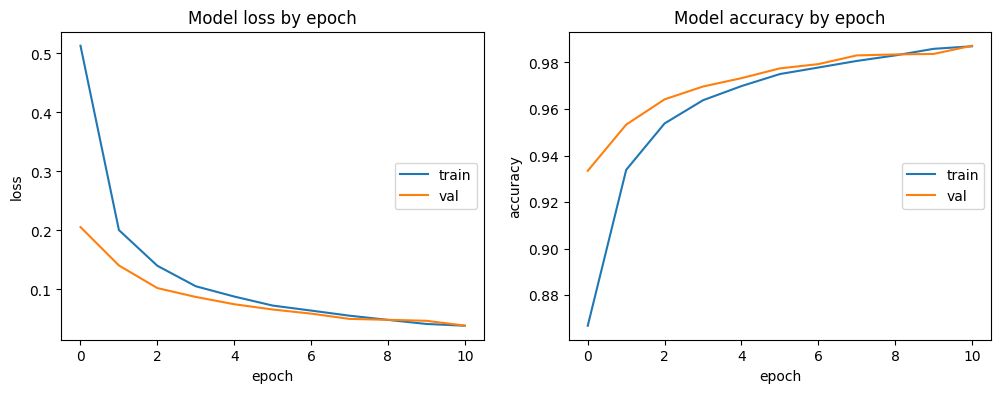

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       504
           1       1.00      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       1.00      1.00      1.00       502
           4       0.99      1.00      1.00       454
           5       1.00      0.99      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.92      0.95       410
           8       0.99      1.00      1.00       477
           9       0.93      0.97      0.95       477
          10       1.00      1.00      1.00       465
          11       0.99      0.99      0.99       472
          12       0.99      1.00      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      1.00       503
          16       1.00      0.99      1.00       459
          17       1.00    

<Axes: >

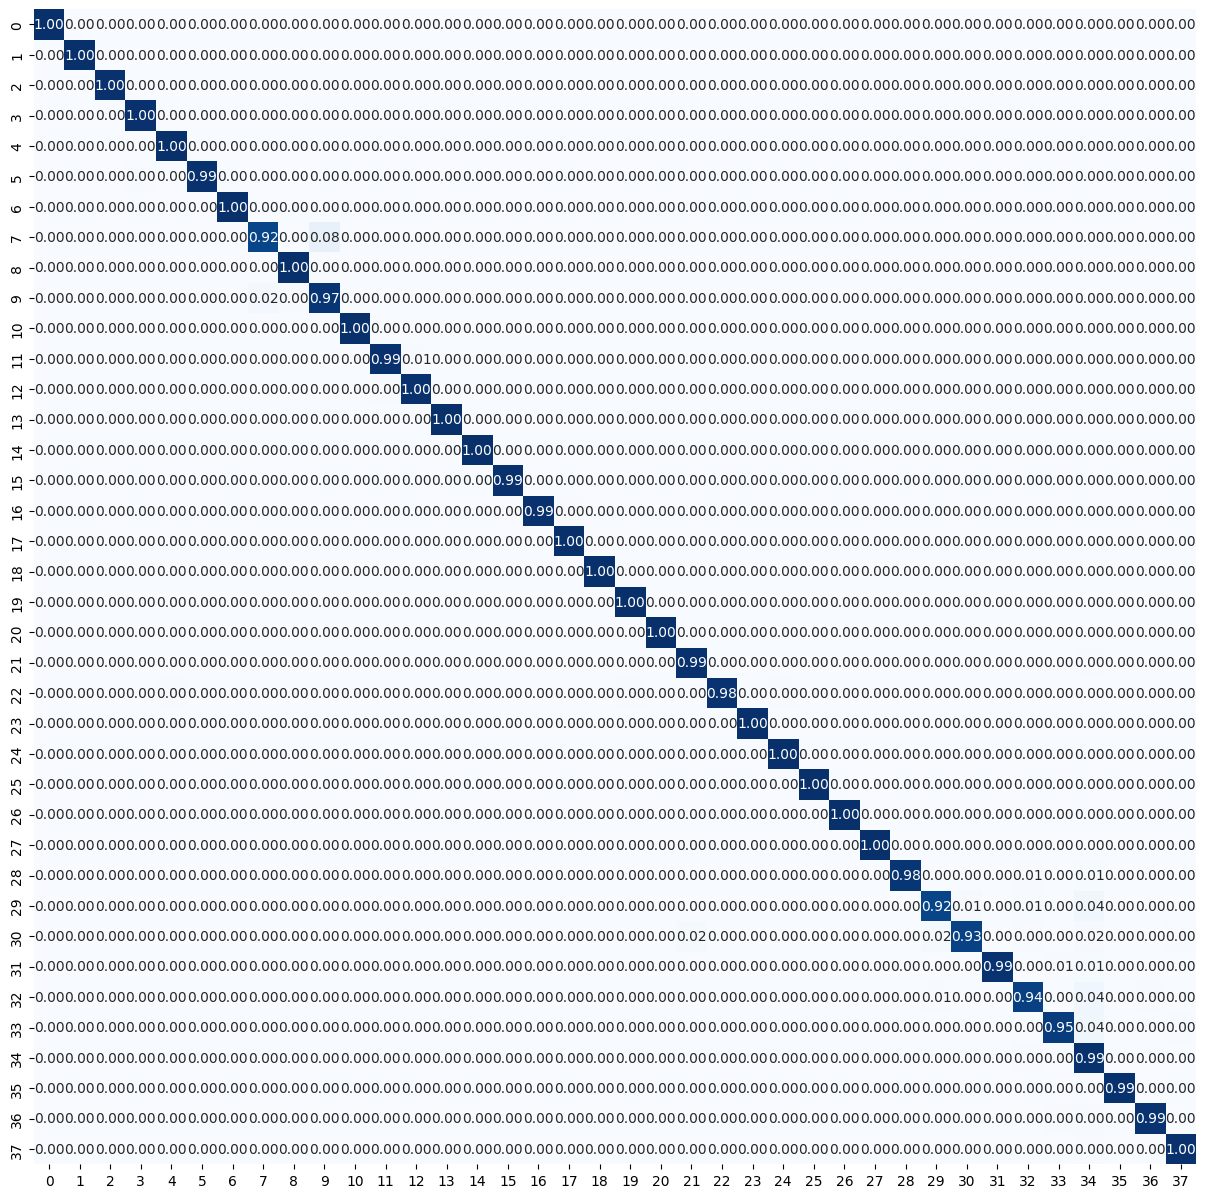

In [19]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(validation_dataset)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap


In [27]:
import datetime
from datetime import date
DATE = date.today().strftime("%Y_%m_%d")
model_path = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/{DATE}_plant_classifier_fine_tuned.keras"

# Save the model
model.save(model_path)
model.save

print(f"Model saved to {model_path}")

Model saved to /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras


In [81]:
import tensorflow as tf

# STEP 1: Use the correct decorator for older TensorFlow versions.
# The registration tool is in `tf.keras.utils` instead of `tf.keras.saving`.
@tf.keras.utils.register_keras_serializable(package="MyCustomFunctions")
def my_registered_preprocess(tensor):
    # Inside, we still call the REAL MobileNetV2 function.
    return tf.keras.applications.mobilenet_v2.preprocess_input(tensor)

# STEP 2: Define your model's path
model_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras"

# STEP 3: Load the model with the correctly registered custom function
try:
    print("Attempting to load model with the correct registered function...")
    model = tf.keras.models.load_model(
        model_path,
        # We map the name 'preprocess_input' from the file to our new function
        custom_objects={'preprocess_input': my_registered_preprocess}
    )
    # STEP 4: Clone the model
    cloned_model = tf.keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())
    print("✅ Model loaded and cloned successfully!")

except Exception as e:
    print(f"❌ An error occurred during loading: {e}")


Attempting to load model with the correct registered function...
✅ Model loaded and cloned successfully!


In [1]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in validation_dataset.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in validation_dataset.take(2)][0])

# Select specific images
images = X[[1, 500, 900, 1300]]
labels = y[[1, 500, 900, 1300]]

NameError: name 'np' is not defined

In [87]:
def grad_cam(img_array, model, target_conv_layer):
    """
    Computes Grad-CAM by manually reconstructing the model's graph path.
    This version includes the fix for the final image shape error.
    """
    # 1. Manually preprocess the input image
    preprocessed_img = tf.keras.applications.mobilenet_v2.preprocess_input(
        tf.cast(img_array, dtype=tf.float32)
    )
    img_array_expanded = tf.expand_dims(preprocessed_img, axis=0)

    # 2. Manually reconstruct the graph path
    base_model_layer = model.get_layer('mobilenetv2_1.00_224')
    global_pool_layer = model.get_layer('global_average_pooling2d')
    dropout_layer = model.get_layer('dropout')
    dense_layer = model.get_layer('dense')

    grad_model_input = base_model_layer.input
    x = base_model_layer.output
    x = global_pool_layer(x)
    x = dropout_layer(x)
    final_preds = dense_layer(x)

    grad_model = tf.keras.Model(
        inputs=grad_model_input,
        outputs=[target_conv_layer.output, final_preds]
    )

    # 3. Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array_expanded)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # --- THIS IS THE CORRECTED SECTION ---
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[0], img_array.shape[1])).numpy()
    
    # Squeeze the heatmap to 2D (224, 224) before applying the colormap
    heatmap_squeezed = np.squeeze(heatmap_resized)
    
    # Apply the colormap to the 2D heatmap
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]
    # --- End of corrected section ---

    # 5. Superimpose heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + (img_array / 255.0)

    return np.clip(superimposed_img, 0, 1), tf.get_static_value(pred_index)

Generating Grad-CAM for layer: 'Conv_1' inside 'mobilenetv2_1.00_224'


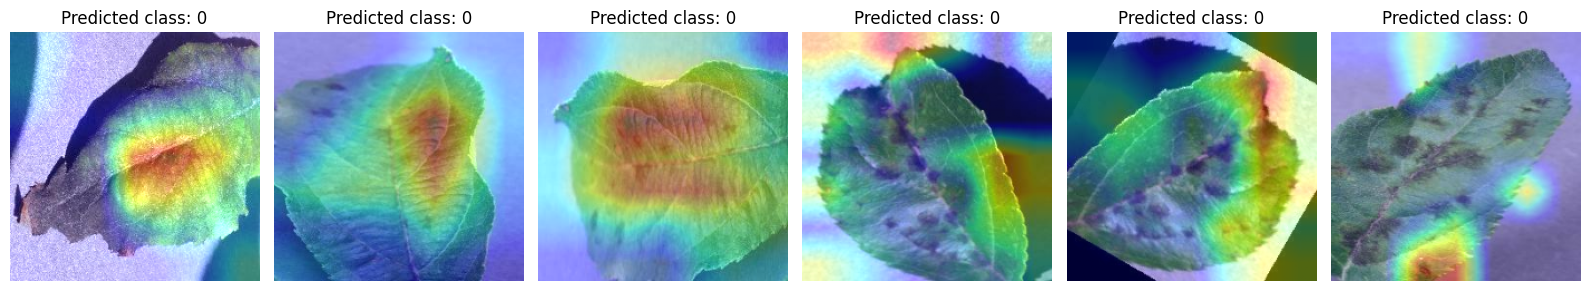

In [88]:
# This call remains the same. Run it after replacing the grad_cam function.
show_grad_cam(images, cloned_model, 'mobilenetv2_1.00_224')

In [68]:
import tensorflow as tf

# STEP 1: Import the function FIRST. This is the crucial step that fixes the error.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# STEP 2: Define your model's path
model_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras"

# STEP 3: Load the model.
# The `custom_objects` dictionary now works because the `preprocess_input`
# function was imported in STEP 1.
try:
    print("Attempting to load model...")
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'preprocess_input': preprocess_input}
    )

    # STEP 4: Clone the model to ensure a clean graph for Grad-CAM
    cloned_model = tf.keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())

    print("✅ Model loaded and cloned successfully!")

except Exception as e:
    print(f"❌ An error occurred: {e}")

Attempting to load model...
❌ An error occurred: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'preprocess_input', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}.

Exception encountered: Could not locate function 'preprocess_input'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 

/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(8, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_O

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [00:43<00:34, 11.39s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [01:06<00:32, 16.11s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [01:29<00:18, 18.88s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [01:52<00:00, 20.26s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [02:15, 22.53s/it]                       


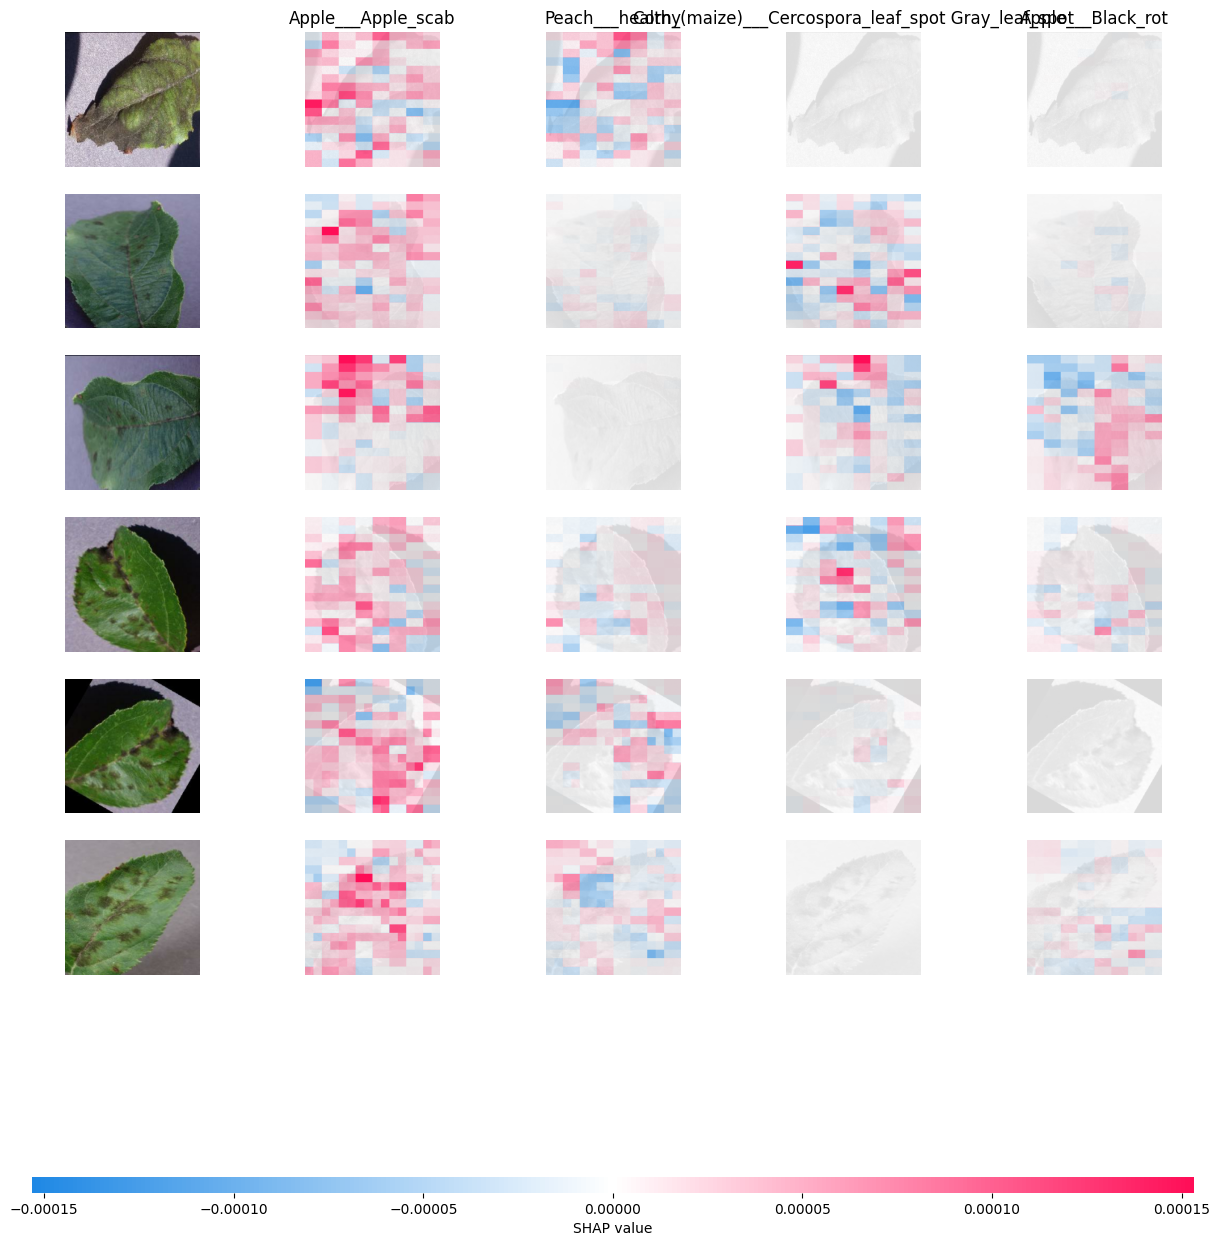

In [89]:
# --- SHAP Explanations ---
masker = shap.maskers.Image("inpaint_telea", images[0].shape) # inpaint_telea blurs the image regions to explain 

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(images, 
                        max_evals=1000,  
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

In [ ]:
# Run this to see the true labels for your images
print("True labels for these images are:", labels)

True labels for these images are: [0 0 0 0 0 0]
